In [ ]:
!pip install transformers
!pip install einops
!pip install triton==2.0.0.dev20221202
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import torch
import transformers
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")

config = transformers.AutoConfig.from_pretrained(
  'mosaicml/mpt-7b-instruct',
  trust_remote_code=True
)
config.attn_config['attn_impl'] = 'triton'

model = transformers.AutoModelForCausalLM.from_pretrained(
  'mosaicml/mpt-7b-instruct',
  config=config,
  torch_dtype=torch.bfloat16,
  trust_remote_code=True
)
model.to(device='cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTForCausalLM(
  (transformer): MPTModel(
    (wte): Embedding(50432, 4096)
    (emb_drop): Dropout(p=0, inplace=False)
    (blocks): ModuleList(
      (0): MPTBlock(
        (norm_1): LPLayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (Wqkv): Linear(in_features=4096, out_features=12288, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (norm_2): LPLayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (ffn): MPTMLP(
          (up_proj): Linear(in_features=4096, out_features=16384, bias=False)
          (act): GELU(approximate='none')
          (down_proj): Linear(in_features=16384, out_features=4096, bias=False)
        )
        (resid_attn_dropout): Dropout(p=0, inplace=False)
        (resid_ffn_dropout): Dropout(p=0, inplace=False)
      )
      (1): MPTBlock(
        (norm_1): LPLayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttent

In [ ]:
promptQE = """
Write a long paragraph about what are the major cities in France. The paragraph has to be more than 300 words.
"""

encoded_input = tokenizer(promptQE, return_tensors='pt')
encoded_input

{'input_ids': tensor([[  187, 10639,   247,  1048, 12494,   670,   752,   403,   253,  2201,
          8238,   275,  6181,    15,   380, 12494,   556,   281,   320,   625,
           685,  7469,  3000,    15,   187]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}

In [ ]:
input_ids = encoded_input['input_ids']
input_ids = input_ids.to(device='cuda')
input_ids.is_cuda

True

In [ ]:
encoded_input = encoded_input.to(device='cuda')

In [ ]:
from typing import Any, Dict, Tuple
import warnings

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import (
    StoppingCriteria,
    StoppingCriteriaList,
    TextIteratorStreamer,
)


INSTRUCTION_KEY = "### Instruction:"
RESPONSE_KEY = "### Response:"
END_KEY = "### End"
INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
PROMPT_FOR_GENERATION_FORMAT = """{intro}
{instruction_key}
{instruction}
{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
)


class InstructionTextGenerationPipeline:
    def __init__(
        self,
        model_name,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        use_auth_token=None,
    ) -> None:
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch_dtype,
            trust_remote_code=trust_remote_code,
            use_auth_token=use_auth_token,
        )

        tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            trust_remote_code=trust_remote_code,
            use_auth_token=use_auth_token,
        )
        if tokenizer.pad_token_id is None:
            warnings.warn(
                "pad_token_id is not set for the tokenizer. Using eos_token_id as pad_token_id."
            )
            tokenizer.pad_token = tokenizer.eos_token
        tokenizer.padding_side = "left"
        self.tokenizer = tokenizer

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.eval()
        self.model.to(device=device, dtype=torch_dtype)

        self.generate_kwargs = {
            "temperature": 0.1,
            "top_p": 0.92,
            "top_k": 0,
            "max_new_tokens": 256,
            "use_cache": True,
            "do_sample": True,
            "eos_token_id": self.tokenizer.eos_token_id,
            "pad_token_id": self.tokenizer.pad_token_id,
            "repetition_penalty": 1.1,  # 1.0 means no penalty, > 1.0 means penalty, 1.2 from CTRL paper
        }

    def format_instruction(self, instruction):
        return PROMPT_FOR_GENERATION_FORMAT.format(instruction=instruction)

    def __call__(
        self, instruction: str, **generate_kwargs: Dict[str, Any]
    ) -> Tuple[str, str, float]:
        s = PROMPT_FOR_GENERATION_FORMAT.format(instruction=instruction)
        input_ids = self.tokenizer(s, return_tensors="pt").input_ids
        input_ids = input_ids.to(self.model.device)
        gkw = {**self.generate_kwargs, **generate_kwargs}
        with torch.no_grad():
            output_ids = self.model.generate(input_ids, **gkw)
        # Slice the output_ids tensor to get only new tokens
        new_tokens = output_ids[0, len(input_ids[0]) :]
        output_text = self.tokenizer.decode(new_tokens, skip_special_tokens=True)
        return output_text

In [ ]:
generate = InstructionTextGenerationPipeline(
    "mosaicml/mpt-7b-instruct",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)

stop_token_ids = generate.tokenizer.convert_tokens_to_ids(["<|endoftext|>"])


# Define a custom stopping criteria
class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_id in stop_token_ids:
            if input_ids[0][-1] == stop_id:
                return True
        return False

/root/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b-instruct/bd1748ec173f1c43e11f1973fc6e61cb3de0f327/attention.py:148: UserWarning: Using `attn_impl: torch`. If your model does not use `alibi` or `prefix_lm` we recommend using `attn_impl: flash` otherwise we recommend using `attn_impl: triton`.
  warnings.warn('Using `attn_impl: torch`. If your model does not use `alibi` or ' + '`prefix_lm` we recommend using `attn_impl: flash` otherwise ' + 'we recommend using `attn_impl: triton`.')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-9-94dd8661fd4c>:50: UserWarning: pad_token_id is not set for the tokenizer. Using eos_token_id as pad_token_id.
  warnings.warn(


In [ ]:
import json
import textwrap

def get_prompt(instruction):
    prompt_template = f"Expansion Following Query with various term. \n\n\n{instruction}\n\n###"
    return prompt_template

# print(get_prompt('What is the meaning of life?'))

def parse_text(text):
        wrapped_text = textwrap.fill(text, width=100)
        print(wrapped_text +'\n\n')
        # return assistant_text

In [ ]:
%%time
prompt = 'What are the major cities in France?'
generated_text = generate(prompt)
parse_text(generated_text)

The largest city and capital of France, Paris has over 2 million inhabitants within its
administrative limits on the Seine River. It's also one of Europe’s leading tourist destinations
with more than 30 million visitors each year. Other large French urban areas include Marseille (1st
in France), Lyon (3rd) Toulouse (4th).


CPU times: user 5.5 s, sys: 1.42 s, total: 6.92 s
Wall time: 5.84 s


In [1]:
!pip install bert_score==0.3.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.8 MB/s eta 0:00:00


In [2]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone https://github.com/Tiiiger/bert_score.git

Cloning into 'bert_score'...
remote: Enumerating objects: 993, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 993 (delta 219), reused 322 (delta 198), pack-reused 638
Receiving objects: 100% (993/993), 1.34 MiB | 5.56 MiB/s, done.
Resolving deltas: 100% (534/534), done.


In [5]:
from bert_score import score

In [6]:
cands = ["Paris is the capital city of France"]
refs = ["What are the major cities in France"]

In [87]:
with open("bert_score/example/hyps.txt") as f:
    cands = [line.strip() for line in f]

with open("bert_score/example/refs.txt") as f:
    refs = [line.strip() for line in f]

cands[2]

'The victim\'s brother said he cannot imagine anyone who would want to harm him,"Finally, it went uphill again at him."'

In [89]:
#문장 단위로 bert score계산후 평균
f="The largest city and capital of France, Paris has been one of Europe’s cultural centers since the Middle Ages.[2] It was established by the Romans as Lutetia,[3][4] then became the seat of government under the Capetian dynasty; it later grew to become the most important centre for art, fashion, science, and philosophy during the 17th century French Renaissance[5] before becoming the center of the French Revolution after being declared the temporary capitol on 22 June 1789 (the date now commemorated annually with the Fête de la Fédération). The city played a central role throughout much of the 19th century as well, such as hosting the Universal Exposition of 1855, serving as host city to the 1900 Summer Olympics held at the Stade de Colombes outside its limits, playing host to the 1937 World Exhibition where architect Hector Guimard created his famous Art Nouveau entrance pavilion called the “Glass House”, or even welcoming more than 5 million visitors when it served as European Capital of Culture in 1998.[6]"
h="What are the major cities in France?"
cands = [sen for sen in f.split(".")]
cands.pop()
#print(len(cands))
print(cands)
refs = [h for i in range(len(cands))]

['The largest city and capital of France, Paris has been one of Europe’s cultural centers since the Middle Ages', '[2] It was established by the Romans as Lutetia,[3][4] then became the seat of government under the Capetian dynasty; it later grew to become the most important centre for art, fashion, science, and philosophy during the 17th century French Renaissance[5] before becoming the center of the French Revolution after being declared the temporary capitol on 22 June 1789 (the date now commemorated annually with the Fête de la Fédération)', ' The city played a central role throughout much of the 19th century as well, such as hosting the Universal Exposition of 1855, serving as host city to the 1900 Summer Olympics held at the Stade de Colombes outside its limits, playing host to the 1937 World Exhibition where architect Hector Guimard created his famous Art Nouveau entrance pavilion called the “Glass House”, or even welcoming more than 5 million visitors when it served as European

In [100]:
#문장 단위로 bert score계산후 평균
f="France stands as Europe’s second-largest country and also its most populated nation; it boasts some sixty million inhabitants across twenty regions (or “regions” for short), including ten providing greater metropolitan areas – like Paris, Lyon, Marseille, Toulouse etc… France hosts two UNESCO World Heritage sites: both Versailles Palace and the city centre of Avignon were listed under this designation while other notable cultural landmarks include the Notre Dame Cathedral de Paris, Sacré Coeur Basilica at Montmartre, Musée d’Orsay, Louvre Museum et al.The official language remains French though over 100 distinct dialects exist throughout the territory, spoken primarily via the Francophone community comprising around 75% of population within Metropolitan France plus nearly 200 nations worldwide who recognize use of the langue française through education programs administered globally from headquarters based near Paris."
h="What are the major cities in France?"
cands = [sen for sen in f.split(".")]
cands.pop()
cands2=[cand.strip() for cand in cands]
cands2
print(cands2)
print(len(cands2))
#print(cands)
refs = [h for i in range(len(cands))]

['France stands as Europe’s second-largest country and also its most populated nation; it boasts some sixty million inhabitants across twenty regions (or “regions” for short), including ten providing greater metropolitan areas – like Paris, Lyon, Marseille, Toulouse etc… France hosts two UNESCO World Heritage sites: both Versailles Palace and the city centre of Avignon were listed under this designation while other notable cultural landmarks include the Notre Dame Cathedral de Paris, Sacré Coeur Basilica at Montmartre, Musée d’Orsay, Louvre Museum et al', 'The official language remains French though over 100 distinct dialects exist throughout the territory, spoken primarily via the Francophone community comprising around 75% of population within Metropolitan France plus nearly 200 nations worldwide who recognize use of the langue française through education programs administered globally from headquarters based near Paris']
2
2


In [105]:
#통째로 계산
f="The largest city and capital of France, Paris has been one of Europe’s cultural centers since the Middle Ages.[2] It was established by the Romans as Lutetia,[3][4] then became the seat of government under the Capetian dynasty; it later grew to become the most important centre for art, fashion, science, and philosophy during the 17th century French Renaissance[5] before becoming the center of the French Revolution after being declared the temporary capitol on 22 June 1789 (the date now commemorated annually with the Fête de la Fédération). The city played a central role throughout much of the 19th century as well, such as hosting the Universal Exposition of 1855, serving as host city to the 1900 Summer Olympics held at the Stade de Colombes outside its limits, playing host to the 1937 World Exhibition where architect Hector Guimard created his famous Art Nouveau entrance pavilion called the “Glass House”, or even welcoming more than 5 million visitors when it served as European Capital of Culture in 1998.[6]"
h="What are the major cities in France?"
cands=[f]
refs=[h]

In [6]:
#통째로 계산
f="France stands as Europe’s second-largest country and also its most populated nation; it boasts some sixty million inhabitants across twenty regions (or “regions” for short), including ten providing greater metropolitan areas – like Paris, Lyon, Marseille, Toulouse etc… France hosts two UNESCO World Heritage sites: both Versailles Palace and the city centre of Avignon were listed under this designation while other notable cultural landmarks include the Notre Dame Cathedral de Paris, Sacré Coeur Basilica at Montmartre, Musée d’Orsay, Louvre Museum et al.The official language remains French though over 100 distinct dialects exist throughout the territory, spoken primarily via the Francophone community comprising around 75% of population within Metropolitan France plus nearly 200 nations worldwide who recognize use of the langue française through education programs administered globally from headquarters based near Paris."
h="What are the major cities in France?"
cands=[f]
refs=[h]

In [61]:
#테스트, bertscore는 거짓말은 못걸러냄
cands=["Paris is the capital of France"]
refs=["What are the major cities in France"]
cands=["I like you"]
refs=["I don't like you"]

In [116]:
cands=["Paris, Lyon and Marseille are three of the most important French metropolitan areas with over 1 million inhabitants each (metropolitan area). They form the core of the Rhine-Alpes-Provence region which includes several other large urban centers such as Toulouse or Nice. The Paris Region counts for nearly 20% of the population of Metropolitan France while hosting only 13% of its territory. It extends beyond the administrative boundaries of Île-de-France by including the agglomeration around Lyon and Marseille.",
       "France, officially known as République française (French Republic), is one of Europe’s most visited countries and its capital city Paris remains among world’s top tourist destinations with over 30 million visitors per year. It also hosts many other important French cities such as Lyon, Marseille or Toulouse which have been selected by UNESCO as World Heritage sites for their rich cultural heritage including Roman amphitheatres, medieval districts and modern architectural landmarks like the Cité de la Musique et du Patrimoine in Lyon.",
       "France, officially known as République française (French Republic), is one of the most visited countries by tourists from all over Europe and around the world due to its rich history, culture, gastronomy, art de vivre and beautiful landscapes ranging from Atlantic Ocean beaches on the west coasts to Alps mountain ranges with ski resorts for winter sports lovers or hiking trails during summer time; Mediterranean Sea coastal regions including famous Côte d’Azur where you can enjoy sunny weather almost every day throughout the year while visiting Nice, Cannes, Saint-Tropez…etc.; Paris - the capital city which hosts many historical monuments such as Eiffel Tower, Notre Dame Cathedral, Louvre Museum etc., and so much more! The country’s population amounts to 67 million people living mainly along the western half of the country bordering the English Channel, North Sea & Atlantic ocean whereas eastern part borders Germany, Luxembourg, Belgium & Switzerland. Major metropolitan areas include Paris, Marseille, Lyon, Toulouse, Bordeaux, Nice, Nantes, Rennes, Strasbourg, Montpellier among others.",
       "France, officially known as République française (French Republic), is one of the most visited countries by tourists all over the world and it’s also considered among the top ten economies worldwide with Paris being its capital city since the 18th century when Louis XIV moved his court from Versailles to the center of the country.The French territory covers 643,801 km2 which makes up 2% of Europe’s total surface area while having a population density of around 200 inhabitants per square kilometer making it the second densest populated European nation after Monaco. It borders Belgium, Luxembourg, Germany, Switzerland, Italy, Spain & Andorra through various mountain ranges such as Alps or Pyrenees but mostly Mediterranean coastline along Atlantic Ocean on West side where you can find some popular tourist destinations like Nice, Cannes, Saint-Tropez etc…",
       "Paris, Lyon and Marseille are three of the largest French metropolitan areas with over 2 million inhabitants each (metropolitan area). They rank among the top 20 most populated urban areas in Europe. Other large cities include Toulouse, Nice, Nantes, Bordeaux, Lille, Rennes or Strasbourg which have between 700 000 and 1 500 000 residents respectively.",
       "The largest city of France, and one of its most important economic centers as well, Paris (originally called “Parthie” by Romans) was founded around 50 BC on the Seine river banks near the present-day Ile de la Cite island where the first Gallo-Roman settlement had been built before. It became the capital of the French kingdom during the Middle Ages after it replaced Orléans which used to host the royal court until the 10th century. In 1682 Louis XIV moved his residence from Versailles back into Paris at the Louvre palace. During the 19th Century, under Napoleon Bonaparte’s rule, Paris grew rapidly with new neighborhoods being created outside the old medieval walls such as Montmartre or the Latin Quarter while many famous monuments were constructed including the Eiffel Tower, Arc de Triomphe, Notre Dame cathedral etc… Today, over 2 million people live within the Paris metropolitan area whose population counts for nearly 20% of the whole country. Other large urban areas include Lyon (3rd biggest), Marseille (6th), Toulouse (11th).",
       "Paris, Lyon and Marseille are all important French metropolitan areas with over 1 million inhabitants each. They form the core of the country’s largest urban area which also includes other large towns such as Toulouse or Nice. Other significant cities include Bordeaux, Rennes, Nantes, Lille, Strasbourg, Montpellier, Tours, Reims, Dijon, Grenoble, Toulon, and Clermont-Ferrand among others.",
       "Paris, Lyon and Marseille are some of the most famous French cities for tourism as well as business trips. Paris is home to one-third of all museums in Europe including Louvre Museum which attracts millions visitors every year with its collection of over 35000 artworks from Egyptians, Greeks, Romans up until modern times. There’s also Disneyland park located at the outskirts of this city where you can enjoy many Disney characters while riding on rollercoasters or visiting shows! Last but not least there’s Notre Dame Cathedral – it took 200 years before it was completed by Victor Hugo who wrote his novel “The Hunchback” based upon this very place during Middle Ages period when gypsies were burned alive inside due to their skin color (which turned out darker).",
       "The largest city and capital of France, Paris sits on both banks of the Seine river between Normandy and Ile-de-France regions with 20 arrondissements (districts) containing over 2 million inhabitants each year. It’s home to some of Europe’s most famous landmarks including Notre Dame Cathedral, Louvre Museum & Eiffel Tower as well as many other museums such as Musee d’Orsay or Centre Pompidou. Other large French urban areas include Marseille located at the Mediterranean Sea coastline which serves as a gateway for trade routes across Western Europe from North Africa via its port; Lyon situated along the Rhone River near the foothills of the Alps also known as “French Silicon Valley” due to its high tech industry growth rate since 2000; Toulouse one of the oldest cities founded by Romans who named it Colonia Agrippa, now hosting Airbus headquarters worldwide plus various aerospace industries; Nice another coastal town serving as a popular tourist destination thanks to Cote D’Azur beaches but also renowned for its flower market Flower Market; Lille where you can visit the impressive Gothic architecture of the Old Stock Exchange Building built around 1350 then enjoy shopping through its pedestrian streets called Grand Place; Nantes often dubbed as ‘the Venice of the West’, this historic seaport hosts numerous canals lined up with cafes and restaurants while being surrounded by medieval walls dating back to 12th century; Bordeaux nicknamed “the cradle of civilization” because of its rich history going all the way back to prehistoric times when first settlements were made there during Stone Age era before becoming Roman colony later on after Julius Caesar conquered Gaul region.",
       "The largest city of metropolitan France, Paris (also called “la Ville de Paris” or just “Paris”), was founded by the Romans as Lutetia and became one of the most important European capitals during the Middle Ages; it remains today one of the world’s leading tourist destinations and economic centers for fashion, gastronomy, culture, science, media, art, architecture, design, luxury goods, commerce, tourism, and trade fairs. Its urban area extends beyond the administrative limits into the neighbouring departments of Seine-Saint-Denis, Hauts-de-Seine, Val-de-Marne, and Seine-et-Marne.[1] It is located on the River Seine at its confluence with the Marne,[2][3] approximately 95 kilometres (59 mi) from the western tip of the country[4] and 120 km (75 miles) south of the English Channel coastline near Calais.[5] With 2,144,828 inhabitants within its administrative boundaries (as of January 2019), Paris is the second most populous French city after Lyon which had 3rd place until recently when it lost this title due to population growth rate decline compared to other big towns such as Toulouse and Nice since 2010 census results were published",
       "The City of Light has been nicknamed la Ville Lumière (“the City of Lights”) because of its status in the history of electric lighting – Paris was the first city in Europe to be illuminated using electric street lights between 1880 and 1881",
       "Paris, Lyon and Marseille are three of the largest French metropolitan areas with over 2 million inhabitants each (metropolitan area). They have been ranked by their GDP per capita on the World Bank’s list of top 20 global city economies since 2020.[4] Other large urban agglomerations include Toulouse, Nice, Nantes, Bordeaux, Montpellier, Rennes, Strasbourg, Lille, Reims or Le Havre which together form the “Greater Paris” conurbation,[5][6] one of Europe’s leading economic regions[7] with a combined population exceeding 12 million people across its entire metropolitan territory as of 2021; it was also designated a UNESCO Creative City of Music in 2018 alongside the other two aforementioned metropolises along with Dijon for music heritage preservation efforts throughout all five communes comprising the Burgundy region collectively known under this designation within the wider Rhine-Alpes Euroregion.",
       "The most populated areas of france include Paris, Marseille and Lyon, all situated on the Mediterranean coastline from South-East towards North East where tourism takes place during summer months for sunbathing purposes through beaches or restaurants along boulevards such as Promenade des Anglais in Nice whose popularity skyrocketed thanks to its film festival renown throughout Europe with Cannes located further north. Other well known French coastal towns worth mentioning would be Biarritz in the Basque country boasting stunning landscapes including mountains stretching downwards into Atlantic ocean waters which also hosts famous golf tournaments every year attracting many high profile sportsmen across world whereas just south east lies St Tropez internationally renowned beach town hosting large numbers of tourists each day between summertime seasons whilst inland locations like Toulouse host aircraft industries due to close proximity airspace near Pyrenees mountain range offering potential travel opportunities within neighbouring Spain without crossing border unlike others serving ferry services only at Calais some 60 miles northwest via Eurotunnel train service connecting passengers comfortably under 2 hours straight up until they reach London taking advantage over Channel tunnel routes spanning around 3hrs 30mins depending upon traffic conditions leading Britain’s biggest city amongst other global metropolises one could consider home worldwide",
       "Paris, Lyon and Marseille are 3 of the largest French metropolitan areas with more than 2 million inhabitants each which constitute the “Grand Paris” metropolis alongside its suburbs (Nord-de-Seine & Seine Saint Denis). In terms of population size, they respectively rank third after Greater London(13.8million)and Tokyo Metropolitan Area(35.3million), ahead of New York City metro area([22]million ) but behind Mexico city[25].2million]. Most populated urban agglomerations do not necessarily correspond exactly to larger administrative units such as regions or departments since some have significant peripheral districts outside the boundaries defined by INSEE for census purposes; several other large towns like Toulouse,[26] Rennes,[27] Nice,[28][29] Nantes,[30]Bordeaux [31]or Montpellier also reach over 1 million.[32] With 12 metro lines including 7 dedicated regional railways called RERs serving 475 stations spread across 360km²massive public transport networks connect all major landmarks within and outermost parts around Ile de France region where 95% of the national capital’s population lives hence buildeth up most dense concentration of human activity known worldwide following Manhattan Island ().\"",
       "France, with its capital Paris and other big cities like Marseille or Lyon, is one of Europe’s most important countries for tourism. Its diverse landscapes are famous all over the world : mountains (Alps, Pyrenees), beaches at Mediterranean sea side, peaceful villages as well as lively towns where you can find theaters, museums… Biggest French cities have their own identity but they also share some things! First of all, it’s easy to travel between them thanks to high-speed trains called TGV which connect almost every single city across whole country. Second thing is cultural diversity. You will find historical monuments such as Notre Dame cathedral in paris or Saint Jacques church in Vienne on top of modern buildings designed by Renzo Piano in Bordeaux or Santiago Calatrava in Nice airport terminal. Not only architecture draws attention but also gastronomy since each region has its specialties such as crêpes from Bretagne/Normandy area or Cassoulet du southern Languedoc Roussillon region",
       "Rome, Paris and London have been historically important global centres for culture, business and politics. They all continue their historic roles today as leading international hubs of commerce, finance, fashion, art, architecture, gastronomy, education, research, entertainment, tourism and sport.The French capital city’s history dates back to at least the 3rd century BC when it was founded by the Romans as Lutetia; it became one of the largest cities on the continent during the Roman Empire with historical high points including hosting both the Council of Clermont (451) and the First Council of Nicaea (325). It later served as the seat of various medieval monarchies before becoming the centre of modern-day republican France under revolutionaries such as Maximilien Robespierre and Napoleon Bonaparte - who entered Paris through the city’s famous Arc de Triomphe whilst inaugurating the Napoleonic Code over 200 years ago. Since then its status as “Paris la Ville” or ‘the City’ continues unabated having become amongst other things Europe’s economic powerhouse home to some 120 embassies across 80 countries making up half of continental Union offices.[1] In terms of national heritage UNESCO lists 35 monuments within the inner city split into six distinctive districts collectively known as the Île-de-France region comprising historic “Centre”, opposite bank (“Right Bank”) “Left Bank”/Latin Quarter cultural quarter plus the administrative Montparnasse district along with similar numbers spread throughout additional neighbourhoods surrounding this core area[2]. While most people associate Paris primarily with museums galleries theatres opéra performances canal boat rides cafés patisseries je ne sais quoi cuisine haute couture shopping Notre Dame cathedral Sacré Coeur basilica Champs Elysées avenue des Champs Élysées flea markets (Les Puces de Vanves), there exists so much else unseen off-grid from stylish brasserie dining experiences retrocafes hole–in-wall bistros boozy bars vintage clothing emporiums live music clubs winding boulevards bookstores fashionable department stores…",
       "France, with its capital Paris located on the Seine river and one of Europe’s largest urban areas at 2 million people, also features many smaller but notable French Cities such as Lyon (2nd most populated city), Marseille(3rd) Toulouse or Nice which all attract tourist from around the world for their unique culture, history, food and nightlife scene! In addition other famous french cites like Nantes, Strasbourg or Montpellier wold definitely deserve visitors attention!",
       "France covers a large area and it’s impossible for me to name all of its big towns or cites, but I can mention some main ones : Paris (capital city), Lyon, Marseille, Toulouse…"
       ]
refs=["What are the major cities in France" for i in range(len(cands))]

In [117]:
P, R, F1 = score(cands, refs, lang="en", verbose=True)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.24 seconds, 14.48 sentences/sec


In [118]:
F1

tensor([0.8395, 0.8300, 0.8144, 0.8210, 0.8432, 0.8240, 0.8311, 0.8406, 0.8157,
        0.8091, 0.8310, 0.8182, 0.8238, 0.8159, 0.8277, 0.7981, 0.8366, 0.8533])

In [119]:
print(f"System level F1 score: {F1.mean():.3f}")

System level F1 score: 0.826


In [93]:
import matplotlib.pyplot as plt

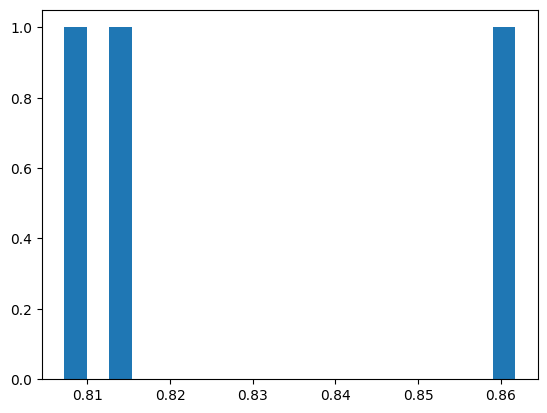

In [94]:
plt.hist(F1, bins=20)
plt.show()

The official language remains French though over 100 distinct dialects exist throughout the territory, spoken primarily via the Francophone community comprising around 75% of population within Metropolitan France plus nearly 200 nations worldwide who recognize use of the langue française through education programs administered globally from headquarters based near Paris


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


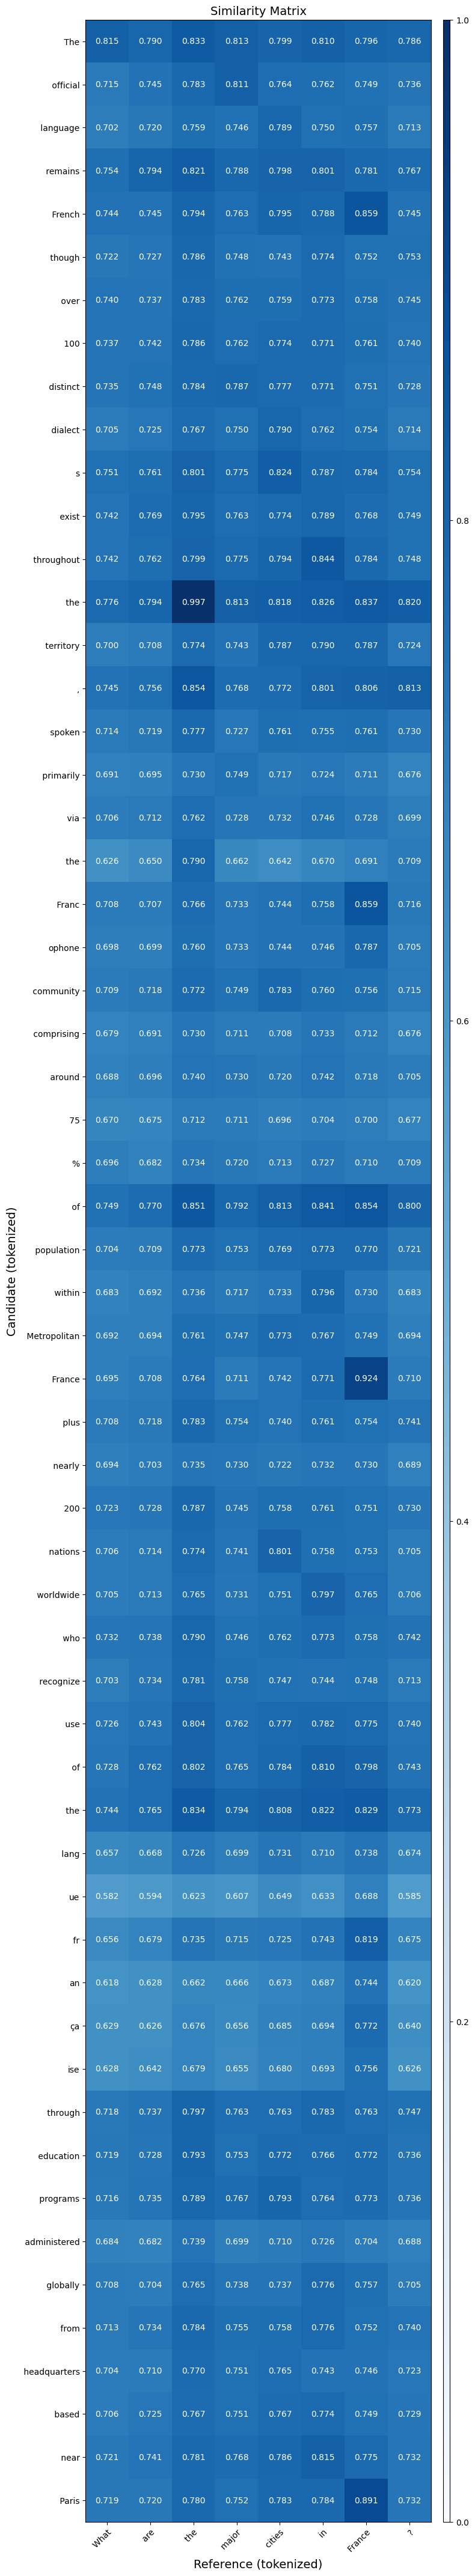

In [104]:
from bert_score import plot_example

cand = cands2[1]
ref = refs[1]
print(cand) 
plot_example(cand, ref, lang="en")

In [72]:
cands = ["people like visiting places abroad","consumers prefer \"imported\" cars"]
refs = ["people like foreign cars","people like foreign cars"]
P, R, F1 = score(cands, refs, lang="en", verbose=True)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 36.22 sentences/sec


In [73]:
F1

tensor([0.9330, 0.9257])

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


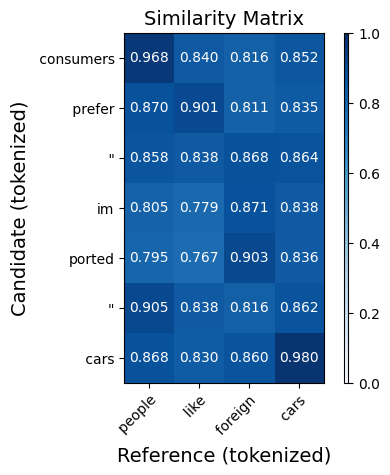

In [74]:
from bert_score import plot_example

cand = cands[1]
ref = refs[1]
plot_example(cand, ref, lang="en")

In [57]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.1 MB/s eta 0:00:00


In [64]:
from evaluate import load
bertscore = load("bertscore")
predictions = ["people like visiting places abroad"]
references = ["consumers prefer imported cars"]
results = bertscore.compute(predictions=predictions, references=references, lang="en")
print(results)

{'precision': [0.9005894660949707], 'recall': [0.9074726700782776], 'f1': [0.904017984867096], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.29.1)'}
